<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/pictures_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preparation

In [1]:
#@title remove repos from disc
%cd /content
!rm -r airbnb_price

/content
rm: cannot remove 'airbnb_price': No such file or directory


In [2]:
#@title Clone repo
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (542/542), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 542 (delta 286), reused 147 (delta 26), pack-reused 0
Receiving objects: 100% (542/542), 3.76 MiB | 9.48 MiB/s, done.
Resolving deltas: 100% (286/286), done.


In [3]:
#@title add paths to library search path
import sys 

sys.path.append("/content/airbnb_price/custom_functions")

In [4]:
#@title Imports and drive
import os
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import requests
from tqdm import tqdm
from scipy.stats.stats import pearsonr

# own modules
import general_utils as gu
import picture_model_utils as pu



from google.colab import drive

#@title Mount drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
#@title define device

# device
device = gu.get_device()
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB
4 CPUs available


# 1. Model thumbnail pictures

In [6]:
# define train, val split
listings = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")
trainsplit, valsplit, _ = gu.train_val_test_split(listings.index)

In [7]:
# information regarding predictor and response
thumbnail_dir = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_raw"

log_price = listings["log_price"]
log_price = log_price.to_dict()

In [8]:
# make train_dataset and val_dataset and respective dataloader with thumbnails
train_dataset = pu.ThumbnailsDataset(thumbnail_dir=thumbnail_dir, response=log_price, split=trainsplit)
val_dataset = pu.ThumbnailsDataset(thumbnail_dir=thumbnail_dir, response=log_price, split=valsplit)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [9]:
# calculate root mse to get reference value for model performance
logprice = []
for i in tqdm(range(len(val_dataset))):
    logprice.append(val_dataset[i][1])

100%|██████████| 1711/1711 [07:53<00:00,  3.61it/s]


In [10]:
mean_logprice = np.mean(logprice)
squared_error = (np.array(logprice) - mean_logprice) ** 2
mean_squared_error = np.mean(squared_error)
root_mean_squared_error = np.sqrt(mean_squared_error)
root_mean_squared_error

0.64899296

In [16]:
#@title define models classes
class Model(torch.nn.Module):
    def __init__(self, feature_extractor, finalizer):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.finalizer = finalizer

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.finalizer(x)
    
        return x

class Finalizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(512)
        self.conv2 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(512)
        self.conv3 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(512)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop1 = torch.nn.Dropout()
        self.linear1 = torch.nn.Linear(in_features = 25088, out_features=256)
        self.bn4 = torch.nn.BatchNorm1d(256)
        self.drop2 = torch.nn.Dropout()
        self.linear2 = torch.nn.Linear(in_features=256, out_features=1)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.drop1(x)
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.drop2(x)
        x = self.linear2(x)

        return x
        

In [17]:
#@title define train functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
    
def train(dataloader, optimizer, model, loss_fn, device, master_bar, scaler):
    model.train()
    epoch_loss = []

    for image, target in fastprogress.progress_bar(dataloader, parent=master_bar):
        
        image, target = image.to(device), target.to(device)
        target = torch.squeeze(target)

        # zero gradient
        optimizer.zero_grad()

        # Forward pass
        prediction = model.forward(image)
        prediction = torch.squeeze(prediction)

        # loss calculation
        loss = loss_fn(prediction, target)

        # Backward pass
        scaler.scale(loss).backward() #loss.backward()
        scaler.step(optimizer) # optimizer.step()
        scaler.update()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(np.sqrt(loss.item()))

    return np.mean(epoch_loss)


def validate(dataloader, model, loss_fn, device, master_bar):
    model.eval()
    epoch_loss = []

    with torch.no_grad():
        for image, target in fastprogress.progress_bar(dataloader, parent=master_bar):
            
            image, target = image.to(device), target.to(device)
            target = torch.squeeze(target)

            # Forward pass
            prediction = model.forward(image)
            prediction = torch.squeeze(prediction)

            # loss calculation
            loss = loss_fn(prediction, target)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(np.sqrt(loss.item()))

    return np.mean(epoch_loss)
    

def run_training(model, optimizer, scheduler, loss_fn, device, num_epochs,
                 train_dataloader, val_dataloader, verbose, 
                 savefolder="training_results1"):
  
    # make path to save performance measures and state dict
    savepath = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_model/" + savefolder
    os.mkdir(savepath)
  
    # technical stuff
    start_time = time.time()
    scaler = torch.cuda.amp.GradScaler()
    master_bar = fastprogress.master_bar(range(num_epochs))

    # instantiate losses
    train_loss = []
    val_loss = []

    for epoch in master_bar:

        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, loss_fn, device, master_bar, scaler)
        #Validate the model
        epoch_val_loss = validate(val_dataloader, model, loss_fn, device, master_bar)

        # update scheduler
        scheduler.step()

        # Save loss and acc for plotting
        train_loss.append(epoch_train_loss)
        val_loss.append(epoch_val_loss)

        if val_loss[-1] <= np.min(val_loss):
            torch.save(model.state_dict(), savepath + "/checkpoint.pt")
            print("saving model...")

        if verbose:
            master_bar.write(
                f'Epoch: {epoch+1}, Train root mse: {epoch_train_loss:.4f}, val root mse: {epoch_val_loss:.4f}')
            
    np.save(savepath + "/trainloss", train_loss)
    np.save(savepath + "/valloss", val_loss)
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_loss, val_loss
    

In [37]:
# define feature extractor
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

# define finalizer
finalizer = Finalizer()

# define model
model = Model(feature_extractor=feature_extractor, finalizer=finalizer)
model = model.to(device)

# freeze parameters in feature extractor
for name, p in model.named_parameters():
    if "feature_extractor" in name:
        p.requires_grad = False

# print parameters that are optimized
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

finalizer.conv1.weight
finalizer.conv1.bias
finalizer.bn1.weight
finalizer.bn1.bias
finalizer.conv2.weight
finalizer.conv2.bias
finalizer.bn2.weight
finalizer.bn2.bias
finalizer.conv3.weight
finalizer.conv3.bias
finalizer.bn3.weight
finalizer.bn3.bias
finalizer.linear1.weight
finalizer.linear1.bias
finalizer.bn4.weight
finalizer.bn4.bias
finalizer.linear2.weight
finalizer.linear2.bias


In [33]:
# define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.1 ** (epoch // 15), 
                                              last_epoch=-1, verbose=True)
loss_fn = torch.nn.MSELoss()

Adjusting learning rate of group 0 to 1.0000e-03.


In [34]:
train_loss, val_loss = run_training(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, device=device, num_epochs=30,
                                    train_dataloader=train_dataloader, val_dataloader=val_dataloader, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-04.
saving model...
Adjusting learning rate of group 0 to 1.0000e-04.
saving model...
Adjusting learning rate of group 0 to 1.

# 2. Evaluation

In [38]:
result_folder = "training_results1"
savepath = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_model/" + result_folder
model.load_state_dict(torch.load(savepath + "/checkpoint.pt"))
trainloss = np.load(savepath + "/trainloss.npy")
valloss = np.load(savepath + "/valloss.npy")

In [39]:
ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for x, y in tqdm(val_dataloader):
        x = x.to(device)
        y_pred = model(x)
        y_pred = list(y_pred.data.cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(y)

100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


(0.4415669794600462, 1.414564233079546e-82)


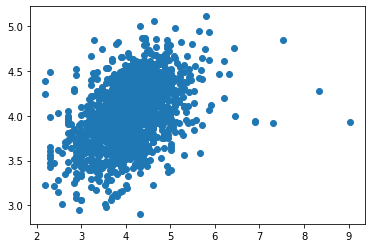

In [40]:
print(pearsonr(ys, ypreds))
plt.scatter(ys, ypreds)
plt.show()

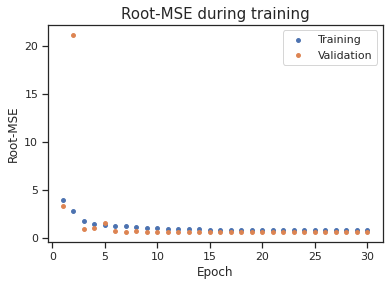

In [41]:
gu.plot("Root-MSE during training", "Root-MSE", trainloss, valloss, yscale='linear', legend=["Training", "Validation"],
         thinning=1, save_path=None)


#3. Explainability

In [ ]:
model()

In [45]:
# get indices of very high and low predictions
sorted_indices = torch.argsort(torch.tensor(ypreds))
sorted_indices_low_prediction = sorted_indices[:5]
sorted_indices_high_prediction = sorted_indices[-5:]



In [46]:
sorted_indices_low_prediction

tensor([ 787, 1510,  198, 1372, 1180])

In [55]:
# low prediction example
with torch.no_grad():
    model = model.eval()
    print(model(val_dataset[787][0].unsqueeze(0).to(device)))

tensor([[2.9044]], device='cuda:0')


In [56]:
sorted_indices_high_prediction

tensor([1027,  399,  759,  680,  721])

In [57]:
# high prediction example
with torch.no_grad():
    model = model.eval()
    print(model(val_dataset[1027][0].unsqueeze(0).to(device)))

tensor([[4.9445]], device='cuda:0')


In [58]:
val_dataset.split[sorted_indices_low_prediction]

array([34039746, 23106156, 13677809, 48650922,  8265848])

In [60]:
val_dataset.split[sorted_indices_high_prediction]

array([40650634, 13402481, 35726559, 23333753, 39225532])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


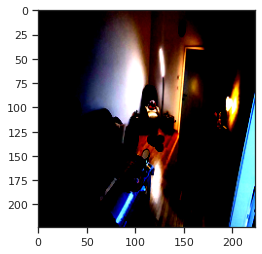

In [79]:
plt.imshow(np.transpose(val_dataset[1180][0].numpy(), (1, 2, 0)))

In [ ]:
# todo make feature masks for some small handpicked images (preferrably images where predicted price was very low or high)
feature_mask = 0

In [ ]:
from captum.attr import visualization as viz
from captum.attr import FeatureAblation



ablator = FeatureAblation(model)

attribution_map = ablator.attribute(
    val_dataset[0][0].unsqueeze(0).to(device),
    target=None,  
    feature_mask=None) # here a feature mask should be included (do not expect useful outcome without it)

In [93]:
target=ypreds[0].to(device).type(torch.LongTensor)

In [92]:
%debug

> /usr/local/lib/python3.7/dist-packages/captum/_utils/common.py(520)_verify_select_column()
    518         len(target) <= len(output.shape) - 1
    519     ), "Cannot choose target column with output shape %r." % (output.shape,)
--> 520     return output[(slice(None), *target)]
    521 
    522 

ipdb> output
tensor([[4.3204]], device='cuda:0')
ipdb> quit



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



In [ ]:
attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels 
attribution_map = np.transpose(attribution_map, (1,2,0))
_ = captum.attr.visualization.visualize_image_attr(attribution_map,
                             method="heat_map",
                             sign="all",
                             show_colorbar=True)

In [ ]:
# plot image without some important areas 
import cv2

cV2_mask = np.array(feature_mask)
cV2_mask[feature_mask == 0] = 1
cV2_mask[feature_mask == 1] = 0
cV2_mask[feature_mask == 2] = 1
cV2_mask[feature_mask == 3] = 0
cV2_mask = np.expand_dims(cV2_mask.squeeze(), axis=2).astype(np.uint8)

img_arr = np.transpose(val_dataset[0].numpy(),  (1,2,0))
img_without_important_areas = cv2.bitwise_and(img_arr, img_arr, mask=cV2_mask)
plt.imshow(img_without_important_areas); plt.axis('off'); plt.show()

In [ ]:
# generate prediction for this ablated image
img_tensor = torch.from_numpy(img_arr)
img_tensor = torch.permute(img_tensor, (2, 0, 1))

model(img_tensor)